In [1]:
import sys
sys.path.append('/home/sharedrive/nafi/traffic/lib/python3.9/site-packages')

import pandas as pd
from chronos import ChronosPipeline
import torch
from table_evaluator import TableEvaluator
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
import numpy as np
from sdv.metadata import Metadata
from sdv.single_table import CopulaGANSynthesizer, TVAESynthesizer, CTGANSynthesizer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from table_evaluator import TableEvaluator
import pickle
import os

In [22]:
itu_train_df = pd.read_csv("./datasets/feature_selected_itu_train.csv")
itu_train_df["Label"].value_counts()

Label
BENIGN                       1430936
DoS_Hulk                      144976
PortScan                      100036
DDoS                           80655
DoS_GoldenEye                   6484
FTP-Patator                     4998
SSH-Patator                     3714
DoS_slowloris                   3651
DoS_Slowhttptest                3464
Bot                             1232
Web_Attack__Brute_Force          949
Web_Attack__XSS                  410
Infiltration                      22
Web_Attack__Sql_Injection         12
Heartbleed                         6
Name: count, dtype: int64

In [23]:
def generate_data_for_classes_tvae(df, classes, num_samples, num_epochs=500):
    synthetic_data = pd.DataFrame()
    metadata = Metadata.detect_from_dataframe(data=df)
    for cls in classes:
        selected_df = df[df["Label"] == cls]
        synthesizer = TVAESynthesizer(metadata, epochs=num_epochs, verbose=True)
        synthesizer.fit(selected_df)
        samples = synthesizer.sample(num_samples)
        
        synthetic_data = pd.concat([synthetic_data, samples])
    return synthetic_data

In [24]:
small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']

def tvae_train(train_df, epochi, file_name):
    for num_sample in [1000]:
        print(f"{file_name} epoch={epochi} samples={num_sample}")

        synthetic_file_path = f"./datasets/{file_name}sample{num_sample}epoch{epochi}.csv"
        
        if os.path.exists(synthetic_file_path):
            print(f"Synthetic data already exists: {synthetic_file_path}")
            synthetic_data_df = pd.read_csv(synthetic_file_path)
        else:
            print("Generating synthetic data...") 
            synthetic_data = generate_data_for_classes_tvae(train_df, small_classes, num_sample, epochi)

            # save and load synthetic data
            synthetic_data.to_csv(f'./datasets/{file_name}sample{num_sample}epoch{epochi}.csv', index=False)
            synthetic_data_df = pd.read_csv(synthetic_file_path)

        # combine synthetic and real data
        combined_train_synth_df = pd.concat([train_df, synthetic_data_df], axis=0, ignore_index=True)

        # divide to x_train and y_train from reduced_train_df
        x_train = combined_train_synth_df.drop(columns=["Label"])
        y_train = combined_train_synth_df["Label"]

        RF_model = RandomForestClassifier(class_weight="balanced", random_state=1002, oob_score=True, verbose=2)
        RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

        reduced_test_df = pd.read_csv("./datasets/feature_selected_itu_test.csv")

        x_test = reduced_test_df.drop(columns=["Label"])
        y_test = reduced_test_df["Label"]

        pred_rf = RF_model.predict(x_test)


        pickle.dump(RF_model, open(f'./models/{file_name}sample{num_sample}epoch{epochi}.pkl', 'wb'))

        print(f"Classification Report for Sample Size {num_sample}:")
        print(classification_report(y_test, pred_rf))

        table_evaluator = TableEvaluator(train_df, synthetic_data_df)
        print(table_evaluator.visual_evaluation())

synthetic_from_itu_tvae epoch=1500 samples=1000
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: -169.988: 100%|███████████████████████| 1500/1500 [02:36<00:00,  9.61it/s]


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  3.1min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.0s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN       1.00      1.00      1.00    410865
                      Bot       0.67      0.78      0.72       354
                     DDoS       1.00      1.00      1.00     23160
            DoS_GoldenEye       1.00      0.99      0.99      1861
                 DoS_Hulk       1.00      1.00      1.00     41626
         DoS_Slowhttptest       0.95      0.99      0.97       994
            DoS_slowloris       0.99      1.00      0.99      1048
              FTP-Patator       1.00      1.00      1.00      1436
               Heartbleed       1.00      0.50      0.67         2
             Infiltration       1.00      0.50      0.67         6
                 PortScan       0.99      1.00      1.00     28728
              SSH-Patator       1.00      0.99      1.00      1067
  Web_Attack__Brute_Force       0.71      0.78      0.75       272
Web_Attack__Sql_I

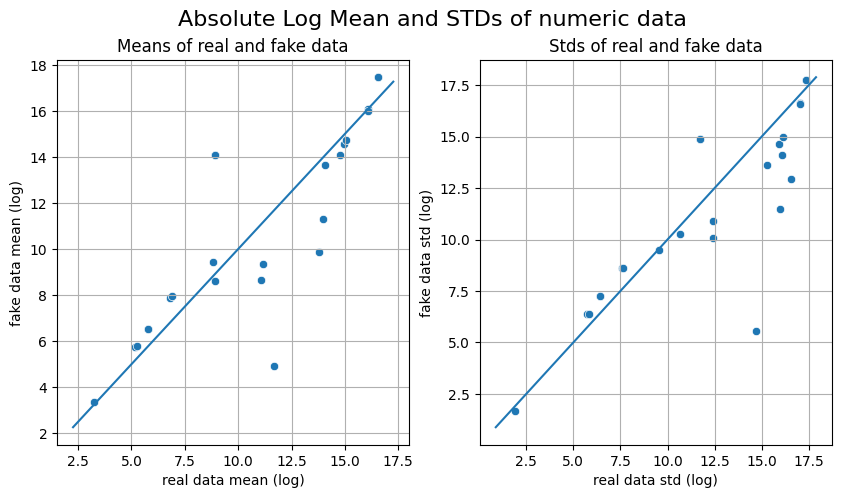

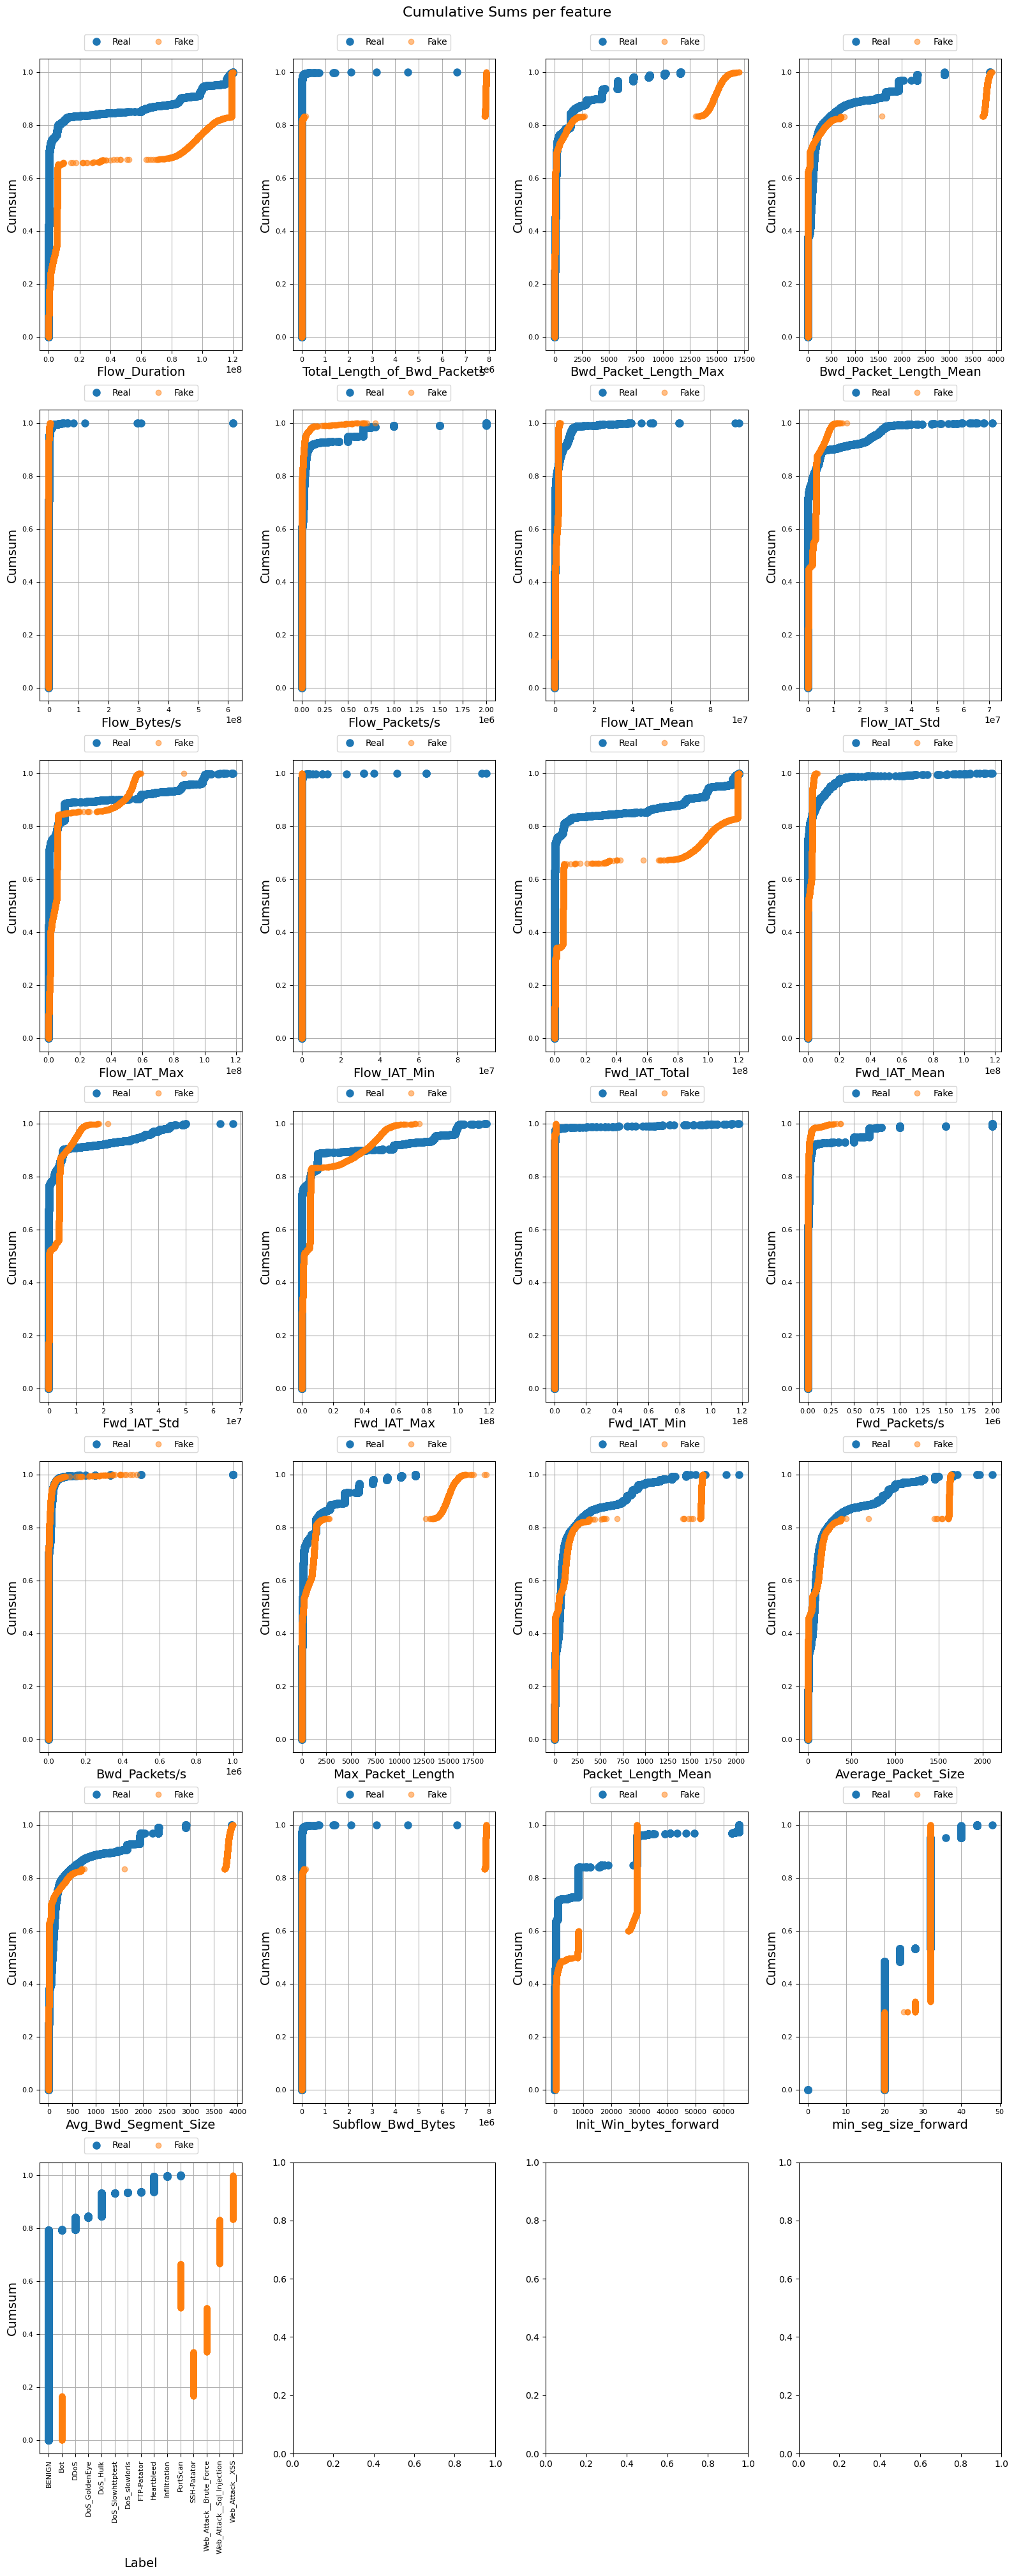

In [ ]:
tvae_train(train_df=itu_train_df, epochi=1500, file_name='synthetic_from_itu_tvae')